<a href="https://colab.research.google.com/github/hasune613/hello-world/blob/main/2020_chapter06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第6章: 機械学習
本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 50. データの入手・整形
***
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

1.   ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2.   情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
1.   抽出された事例をランダムに並び替える．
2.   抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2021-11-03 06:53:14--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  57.2MB/s    in 0.5s    

2021-11-03 06:53:15 (57.2 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [ ]:
!wc -l ./newsCorpora.csv


422937 ./newsCorpora.csv


In [ ]:
!head -10 ./newsCorpora.csv

1	Fed official says weak data caused by weather, should not slow taper	http://www.latimes.com/business/money/la-fi-mo-federal-reserve-plosser-stimulus-economy-20140310,0,1312750.story\?track=rss	Los Angeles Times	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.latimes.com	1394470370698
2	Fed's Charles Plosser sees high bar for change in pace of tapering	http://www.livemint.com/Politics/H2EvwJSK2VE6OF7iK1g3PP/Feds-Charles-Plosser-sees-high-bar-for-change-in-pace-of-ta.html	Livemint	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.livemint.com	1394470371207
3	US open: Stocks fall after Fed official hints at accelerated tapering	http://www.ifamagazine.com/news/us-open-stocks-fall-after-fed-official-hints-at-accelerated-tapering-294436	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.ifamagazine.com	1394470371550
4	Fed risks falling 'behind the curve', Charles Plosser says	http://www.ifamagazine.com/news/fed-risks-falling-behind-the-curve-charles-plosser-says-294430	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www

In [ ]:
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
#データの呼び込み
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
# df.PUBLISHER.tolist()

# データの抽出
df= df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

#データの分割
train,valid_test = train_test_split(df,test_size = 0.2, shuffle=True,random_state=123, stratify=df['CATEGORY'])
valid,test = train_test_split(valid_test, test_size = 0.5,shuffle=True, random_state=123, stratify = valid_test['CATEGORY'])

#データの保存
train.to_csv('./train.txt',sep='\t',index = False)
valid.to_csv('./valid.txt',sep='\t',index = False)
test.to_csv('./test.txt',sep='\t',index = False)

#事例数の確認
print(' 【学習データ】')
print(train['CATEGORY'].value_counts())
print(' 【検証データ】')
print(valid['CATEGORY'].value_counts())
print(' 【評価データ】')
print(test['CATEGORY'].value_counts())

 【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
 【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
 【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


## 51. 特徴量抽出
***
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [ ]:
import string
import re

def preprocessing(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  #string.punctuation=!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~を同じ長さの32個分の' '（スペース）で置換 
  text = text.translate(table) 
  text = text.lower()#小文字化
  text = re.sub('[0-9]+','0',text)#数字列を0に置換
  return text  

In [ ]:
df = pd.concat([train,valid,test],axis=0)
df.reset_index(drop=True, inplace=True)

df['TITLE']  = df['TITLE'].map(lambda x :  preprocessing(x))
df.head()

,TITLE,CATEGORY
0,refile update 0 european car sales up for sixt...,b
1,amazon plans to fight ftc over mobile app purc...,t
2,kids still get codeine in emergency rooms desp...,m
3,what on earth happened between solange and jay...,e
4,nato missile defense is flight tested over hawaii,b


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#データの分割
train_valid ,test= df[:len(train) + len(valid)],df[len(train) + len(valid):] #train_valid(12020), test(1336)

TfidfVectorizer
vec_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,2))

#ベクトル化
X_train_valid = vec_tfidf.fit_transform(train_valid['TITLE'])
X_test = vec_tfidf.transform(test['TITLE'])

# ベクトルをデータフレームに変換
X_train_valid = pd.DataFrame(X_train_valid.toarray(), columns=vec_tfidf.get_feature_names())
X_test = pd.DataFrame(X_test.toarray(),columns=vec_tfidf.get_feature_names())

#データの分割
X_train ,X_valid = X_train_valid[:len(train)],X_train_valid[len(train):]
# len(X_train), len(X_valid)

#データの保存
X_train.to_csv('./train.feature.txt',sep='\t', index = False)
X_valid.to_csv('./valid.feature.txt',sep='\t', index = False)
X_test.to_csv('./test.feature.txt',sep='\t', index = False)

In [ ]:
X_train.shape

(10684, 2815)

## 52. 学習
***
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [ ]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(random_state=123, max_iter = 1000)
lg.fit(X_train,train['CATEGORY'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## 53. 予測
***
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [ ]:
import numpy as np

def score_lg(lg, X):
  return [np.max(lg.predict_proba(X) , axis=1), lg.predict(X)]

In [ ]:
train_pred = score_lg(lg,X_train)
test_pred = score_lg(lg,X_test)

print(train_pred)
print(test_pred)


[array([0.84027948, 0.67904336, 0.55638881, ..., 0.86051   , 0.61359296,
       0.90828249]), array(['b', 't', 'm', ..., 'b', 'm', 'e'], dtype=object)]
[array([0.85872966, 0.83026019, 0.95798309, ..., 0.95016115, 0.9164933 ,
       0.74312599]), array(['e', 'e', 'b', ..., 'e', 'e', 't'], dtype=object)]


## 54. 正解率の計測
***
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ。

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
train_accuracy = accuracy_score(train['CATEGORY'],train_pred[1])
test_accuracy = accuracy_score(test['CATEGORY'],test_pred[1])
print(f'【正解率（学習用）】: {train_accuracy:.3f}')
print(f'【正解率（評価用）】: {test_accuracy:.3f}')

【正解率（学習用）】: 0.927
【正解率（評価用）】: 0.885


## 55. 混同行列の作成
***
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

[[4344   93    8   56]
 [  52 4173    2    8]
 [  96  125  494   13]
 [ 192  133    7  888]]


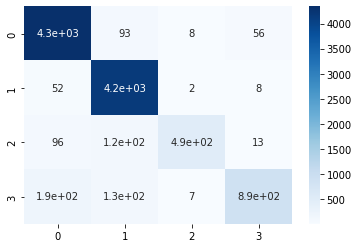

In [ ]:
train_cm = confusion_matrix(train['CATEGORY'],train_pred[1])
print(train_cm)
sns.heatmap(train_cm, annot=True, cmap='Blues')
plt.show()

[[528  20   2  13]
 [ 12 516   1   1]
 [ 11  26  52   2]
 [ 38  26   1  87]]


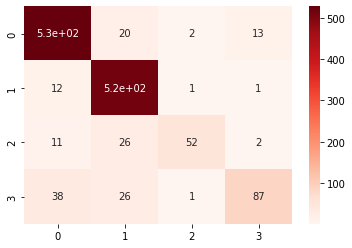

In [ ]:
test_cm = confusion_matrix(test['CATEGORY'],test_pred[1])
print(test_cm)
sns.heatmap(test_cm, annot=True, cmap='Reds')
plt.show()

## 56. 適合率，再現率，F1スコアの計測
***
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score

In [ ]:
def calculate_scores(y_true,y_pred):

  #適合率 正予測の正答率(TP/TP+FP)
  precision = precision_score(test['CATEGORY'],test_pred[1],average=None, labels=['b','e','t','m'])# Noneを指定するとクラスごとの精度をndarrayで返す
  precision = np.append(precision,precision_score(y_true, y_pred, average = 'micro'))# 末尾にマイクロ平均を追加
  precision = np.append(precision,precision_score(y_true, y_pred, average = 'macro'))# 末尾にマクロ平均を追加
  
  #再現率 正に対する正答率(TP/TP+FN)          
  recall = recall_score(test['CATEGORY'],test_pred[1],average=None,labels=['b','e','t','m'])
  recall = np.append(recall,recall_score(y_true,y_pred,average='micro'))
  recall = np.append(recall,recall_score(y_true,y_pred,average='macro'))

  #F1スコア 適合率と再現率の調和平均(2*(Precision×Recal)/(Precision+Recall))
  f1 = f1_score(test['CATEGORY'],test_pred[1],average=None,labels=['b','e','t','m'])
  f1 = np.append(f1,f1_score(y_true,y_pred,average='micro'))
  f1 = np.append(f1,f1_score(y_true,y_pred,average='macro'))

  scores = pd.DataFrame({'適合率':precision,
                         '再現率':recall,
                         'F1':f1},
                        index = ['b','e','t','m','マイクロ平均','マクロ平均'])
  return scores


In [ ]:
pd.options.display.precision = 3 # 小数点以下3桁まで表示
calculate_scores(test['CATEGORY'],test_pred[1])

,適合率,再現率,F1
b,0.896,0.938,0.917
e,0.878,0.974,0.923
t,0.845,0.572,0.682
m,0.929,0.571,0.707
マイクロ平均,0.885,0.885,0.885
マクロ平均,0.887,0.764,0.807


## 57. 特徴量の重みの確認
***
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [ ]:
features = X_train.columns.values 
# features ['0m', '0million', '0nd', ..., 'zac efron', 'zendaya', 'zone'],
# len(set(features))
index = [i for i in range(1,11)]
for c, coef in zip(lg.classes_,lg.coef_):#lg.classes_,['b', 'e', 'm', 't'],
  print(f'【カテゴリ】{c}')
  best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]],columns=['重要度上位10'],index = index).T
  worst10 = pd.DataFrame(features[np.argsort(coef)[:10]],columns=['重要度下位10'],index = index).T
  display(pd.concat([best10,worst10],axis=0))
  print('\n')

【カテゴリ】b


,1,2,3,4,5,6,7,8,9,10
重要度上位10,bank,fed,china,ecb,stocks,euro,obamacare,oil,yellen,dollar
重要度下位10,video,ebola,the,her,and,she,apple,google,star,microsoft




【カテゴリ】e


,1,2,3,4,5,6,7,8,9,10
重要度上位10,kardashian,chris,her,movie,star,film,paul,he,wedding,she
重要度下位10,us,update,google,study,china,gm,ceo,facebook,apple,says




【カテゴリ】m


,1,2,3,4,5,6,7,8,9,10
重要度上位10,ebola,study,cancer,drug,mers,fda,cases,cdc,could,cigarettes
重要度下位10,facebook,gm,ceo,apple,bank,deal,google,sales,climate,twitter




【カテゴリ】t


,1,2,3,4,5,6,7,8,9,10
重要度上位10,google,facebook,apple,microsoft,climate,gm,nasa,tesla,comcast,heartbleed
重要度下位10,stocks,fed,her,percent,drug,american,cancer,ukraine,still,shares


## 58. 正則化パラメータの変更
***
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [ ]:
a = np.logspace(1, 10,10,base=2)#base(基数(底))=2, 2^1 ～ 2^10 までを値に持つ配列を生成
# a = np.logspace(1, 10)
print(a)
# b = np.logspace(-5,4,10,base=10)
# print(b)

[   2.    4.    8.   16.   32.   64.  128.  256.  512. 1024.]


In [ ]:
from tqdm import tqdm

result = []
for C in tqdm(np.logspace(-5, 4,10,base=10)):
  lg = LogisticRegression(random_state=123,max_iter=100,C=C)
  lg.fit(X_train,train['CATEGORY'])

  train_pred = score_lg(lg,X_train)
  valid_pred = score_lg(lg,X_valid)
  test_pred = score_lg(lg,X_test)

  train_accuracy = accuracy_score(train['CATEGORY'],train_pred[1])
  valid_accuracy = accuracy_score(valid['CATEGORY'],valid_pred[1])
  test_accuracy = accuracy_score(test['CATEGORY'],test_pred[1])

  result.append([C,train_accuracy,valid_accuracy,test_accuracy])

 50%|█████     | 5/10 [00:28<00:34,  6.97s/it]/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 60%|██████    | 6/10 [00:54<00:54, 13.51s/it]/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver

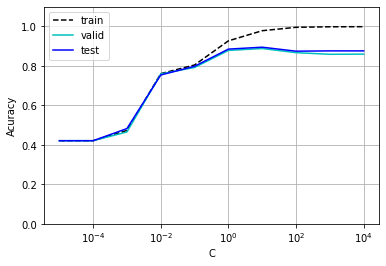

In [ ]:
# 視覚化
result = np.array(result).T

plt.plot(result[0],result[1],label='train',color = 'black',linestyle='dashed')
plt.plot(result[0],result[2],label='valid',color = 'c')
plt.plot(result[0],result[3],label='test',color = 'blue')
plt.ylim(0,1.1)
plt.ylabel('Acuracy')
plt.xscale('log')
plt.xlabel('C')
plt.legend()
plt.grid()
plt.show()

## 59. ハイパーパラメータの探索
***
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [ ]:
!pip install -q optuna

     |████████████████████████████████| 308 kB 10.3 MB/s 
     |████████████████████████████████| 80 kB 7.3 MB/s 
     |████████████████████████████████| 209 kB 61.2 MB/s 
     |████████████████████████████████| 75 kB 4.3 MB/s 
     |████████████████████████████████| 49 kB 6.2 MB/s 
     |████████████████████████████████| 144 kB 51.8 MB/s 
     |████████████████████████████████| 111 kB 49.0 MB/s 


In [ ]:
import optuna

In [ ]:
def objective(trial):
  l1_ratio = trial.suggest_uniform('l1_ratio' , 0,1)
  C = trial.suggest_loguniform('C',1e-4,1e+4)

  lg = LogisticRegression(
       max_iter=100, 
       penalty='elasticnet',
       solver ='saga',
       l1_ratio = l1_ratio,
       C = C ,
       random_state = 123)
  lg.fit(X_train,train['CATEGORY'])
  valid_pred = score_lg(lg,X_valid)
  valid_accuracy = accuracy_score(valid['CATEGORY'],valid_pred[1])

  return valid_accuracy                                

In [ ]:
study = optuna.create_study(direction = 'maximize')# 最大化
study.optimize(objective,n_trials = 3)

print('Best trial : ')
trial = study.best_trial
print(f'Value : {trial.value:.3f}')
print('Params : ')
for key , value in trial.params.items():
  print(f'{key}:{value}')

[I 2021-11-03 07:00:42,015] A new study created in memory with name: no-name-e2c57fb9-26eb-4515-8ade-106f1683df74
[I 2021-11-03 07:00:43,232] Trial 0 finished with value: 0.4214071856287425 and parameters: {'l1_ratio': 0.5200293419750881, 'C': 0.00023441612850870947}. Best is trial 0 with value: 0.4214071856287425.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[I 2021-11-03 07:03:10,924] Trial 1 finished with value: 0.874251497005988 and parameters: {'l1_ratio': 0.3370199199251557, 'C': 24.56900045633399}. Best is trial 1 with value: 0.874251497005988.
[I 2021-11-03 07:03:15,385] Trial 2 finished with value: 0.39595808383233533 and parameters: {'l1_ratio': 0.09565938970974786, 'C': 0.00014818802421194123}. Best is trial 1 with value: 0.874251497005988.


Best trial : 
Value : 0.874
Params : 
l1_ratio:0.3370199199251557
C:24.56900045633399


In [ ]:
l1_ratio = trial.params['l1_ratio']
C = trial.params['C']

lg = LogisticRegression(
    max_iter = 10,
    penalty = 'elasticnet',
    solver = 'saga',
    l1_ratio = l1_ratio,
    C = C,
    random_state = 123
)
lg.fit(X_train,train['CATEGORY'])

train_pred = score_lg(lg,X_train)
valid_pred = score_lg(lg,X_valid)
test_pred = score_lg(lg,X_test)

train_accuracy = accuracy_score(train['CATEGORY'],train_pred[1])
valid_accuracy = accuracy_score(valid['CATEGORY'],valid_pred[1])
test_accuracy = accuracy_score(test['CATEGORY'],test_pred[1])

print(f'正解率（学習データ）: {train_accuracy:.3f}')
print(f'正解率（検証データ）: {valid_accuracy:.3f}')
print(f'正解率（評価データ）: {test_accuracy:.3f}')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



正解率（学習データ）: 0.981
正解率（検証データ）: 0.884
正解率（評価データ）: 0.887


In [ ]:
!pip install -q xgboost

In [ ]:
import xgboost  as xgb

In [ ]:
params={'objective': 'multi:softmax', 
        'num_class': 4,
        'eval_metric': 'mlogloss',
        'colsample_bytree': 1.0, 
        'colsample_bylevel': 0.5,
        'min_child_weight': 1,
        'subsample': 0.9, 
        'eta': 0.1, 
        'max_depth': 5,
        'gamma': 0.0,
        'alpha': 0.0,
        'lambda': 1.0,
        'num_round': 100,
        'early_stopping_rounds': 50,
        'verbosity': 0
        }


In [ ]:
category_dict = {'b' : 0, 'e' :1,'t': 2, 'm': 3}
y_train = train['CATEGORY'].map(lambda x : category_dict[x])
y_valid = valid['CATEGORY'].map(lambda x : category_dict[x])
y_test = test['CATEGORY'].map(lambda x : category_dict[x]) 
dtrain = xgb.DMatrix(X_train,label = y_train)
dvalid = xgb.DMatrix(X_valid,label = y_valid)
dtest = xgb.DMatrix(X_test,label = y_test)

In [ ]:
num_round = params.pop('num_round')
early_stopping_rounds = params.pop('early_stopping_rounds')
watchlist = [(dtrain,'train'), (dvalid,'eval')]
model = xgb.train(params,dtrain,num_round,evals = watchlist,early_stopping_rounds=early_stopping_rounds)

In [ ]:
train_pred = model.predict(dtrain,ntree_limit = model.best_ntree_limit)
valid_pred = model.predict(dvalid,ntree_limit = model.best_ntree_limit)
test_pred = model.predict(dtest,ntree_limit = model.best_ntree_limit)

train_accuracy = accuracy_score(y_train,train_pred)
valid_accuracy = accuracy_score(y_valid,valid_pred)
test_accuracy = accuracy_score(y_test,test_pred)

print(f'正解率（学習データ）： {train_accuracy:.3f}')
print(f'正解率（検証データ）： {valid_accuracy:.3f}')
print(f'正解率（評価データ）： {test_accuracy:.3f}')

正解率（学習データ）： 0.820
正解率（検証データ）： 0.805
正解率（評価データ）： 0.796
